<a href="https://colab.research.google.com/github/chrishuskey/DS-Unit-2-Applied-Modeling/blob/master/Sprint_Challenge_7_DS_Unit_2_Sprint_3_Applied_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍔

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Install Packages & Setup:

In [0]:
%%capture

# Install packages:
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [0]:
# Import libraries we will use:
import pandas as pd
import numpy as np

import re
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

In [0]:
train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

not_test = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert not_test.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [0]:
# Separate not_test into train and val sets:
train, val = train_test_split(not_test, train_size=0.80, stratify=not_test['Fail'], random_state=42)

## Data Prep. & Feature Engineering:

In [0]:
target = 'Fail'

In [0]:
def data_prep(dataframe):
    """Implement data prep. on any data set fed in as an argument."""
    
    # Make a copy to operate on:
    df = dataframe.copy()
    
    # Change to best data types:
    df['Inspection Date'] = pd.to_datetime(df['Inspection Date'], infer_datetime_format=True)
    
# Re-format messy features to get the data we really need:
    df['Facility Type'] = df['Facility Type'].str.lower()
    
    # [?? To do:  Remove any spaces at start or end of string ??]
    
    # Temporarily convert NaNs to string "nan" so we can use Pandas str operations:
    # df['Facility Type'].replace({np.NaN, 'unknown'}, inplace=True)
    df['Facility Type'].fillna(value='missing', inplace=True)

    restaurant = daycare = df['Facility Type'].str.contains('restaurant')
    grocery = daycare = df['Facility Type'].str.contains('grocery')
    school = daycare = df['Facility Type'].str.contains(r'^school$', regex=True)
    bakery = daycare = df['Facility Type'].str.contains(r'^bakery$', regex=True)
    daycare = df['Facility Type'].str.contains('daycare|children', regex=True)
    tavern = df['Facility Type'].str.contains('tavern|liquor|alcohol')

    df.loc[restaurant, 'Facility Type'] = 'Restaurant'
    df.loc[grocery, 'Facility Type'] = 'Grocery Store'
    df.loc[school, 'Facility Type'] = 'School'
    df.loc[daycare, 'Facility Type'] = "Daycare & Children's Services"
    df.loc[bakery, 'Facility Type'] = 'Bakery'
    df.loc[tavern, 'Facility Type'] = 'Bar/Tavern or Liquor Store'
    
    # Make 'Risk' values clearer:
    df.replace({'Risk 3 (Low)': 'Low', 'Risk 2 (Medium)': 'Medium', 'Risk 1 (High)': 'High'}, inplace=True)
    
    # Violations:  There are thousands of unique values, but they all fall into 30-40 categories --> get cat. #s:
    df['Violation Number'] = df['Violations'].str.split(pat='.').str.get(0)
    # df['Violation Number'] = np.where(df['Violation Number'].isnull(), np.NaN, df['Violation Number'].astype('int32'))
    
    # [?? To do:  Format more fully if time allows: 'Facility Type', Inspection Type', 'Violation Number' (convert to int) ??]

# Feature engineering:  New features:
    df['Inspection Date Year'] = df['Inspection Date'].dt.year
    df['Inspection Date Month'] = df['Inspection Date'].dt.month
    
    # Convert string "nan" and other missing value markers to NaN:
    df.replace({'missing': np.NaN}, inplace=True)
    
# Drop redundant, static (no variance) and/or otherwise useless columns:
    df = df.drop(columns=['Location', 'Inspection Date', 'Inspection ID', 'DBA Name', 
                          'AKA Name', 'License #', 'Address', 'City', 'State'])
    
# Data leakage!  Remove the information on violations, which leaks data because it tells us the result of the inspection!
    df = df.drop(columns=['Violations', 'Violation Number'])
    
    return df

In [0]:
train = data_prep(train)
val = data_prep(val)
test = data_prep(test)

In [0]:
# Take a look at our training data with Pandas profiling:
import pandas_profiling

train_profile_report = train.profile_report(
    check_correlation_pearson=False, 
    correlations={
        'pearson': False, 
        'spearman': False, 
        'kendall': False, 
        'phi_k': False, 
        'cramers': False, 
        'recoded':False
    }, 
    plot={'histogram': {'bayesian_blocks_bins': False}}
)
train_profile_report

## Feature Selection:

### Starting features:

In [0]:
# Define starter features and target:  Using all features (pre-feature selection):
target = 'Fail'

features = train.columns.tolist()
features.remove(target)

In [0]:
# Features matrices and target vectors for train and val sets:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# Check to make sure X matrices have the same numbers of columns:
assert X_train.shape[1] == X_val.shape[1] == X_test.shape[1]

## Baseline:

### Baseline 1:  Dummy Model:  Majority Classifier:

In [0]:
y_train.value_counts(dropna=False, normalize=True)

0    0.74138
1    0.25862
Name: Fail, dtype: float64

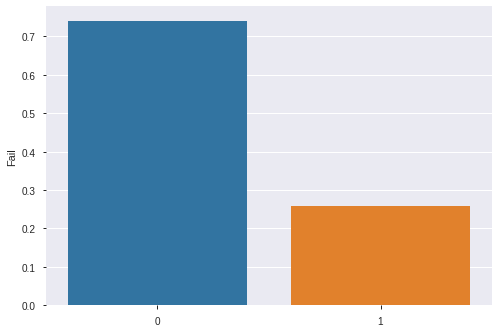

In [0]:
sns.barplot(x=y_train.value_counts(normalize=True).index, 
           y=y_train.value_counts(normalize=True));

In [0]:
majority_class = y_train.mode()[0]

In [0]:
# Get relevant score for our Baseline 1: Majority Classifier dummy model:
y_true_val = y_val
y_pred_b1_val = [majority_class] * len(y_val)

# Get confusion matrix:
cm_b1_val = pd.DataFrame(confusion_matrix(y_true_val, y_pred_b1_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_b1_val.loc['actual_1', 'pred_1']
FN = cm_b1_val.loc['actual_1', 'pred_0']
FP = cm_b1_val.loc['actual_0', 'pred_1']
TN = cm_b1_val.loc['actual_0', 'pred_0']

print('\nBaseline 1:  Majority Classifier Performance:\n')
print(f'Accuracy: {accuracy_score(y_true_val, y_pred_b1_val):.3f}')                      # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall (TPR): {recall_score(y_true_val, y_pred_b1_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'Precision: {precision_score(y_true_val, y_pred_b1_val):.3f}')                    # TP / (TP + FP)
print(f'False Negative Rate ("Miss Rate"): {FN / (FN + TP):.3f}')


Baseline 1:  Majority Classifier Performance:

Accuracy: 0.741
Recall (TPR): 0.000
Precision: 0.000
False Negative Rate ("Miss Rate"): 1.000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
# Confusion matrix (normalized):
cm_b1_val / cm_b1_val.sum().sum()

,pred_0,pred_1
actual_0,0.741429,0.0
actual_1,0.258571,0.0


### Baseline 2:  Logistic Regression:

In [0]:
# [?? To do:  Run a logregcv for comparison if time allows ??]

### Baseline 3:  Single DecisionTree Classifier:

In [0]:
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    DecisionTreeClassifier(min_samples_leaf=2, random_state=42)
)

# Fit on training data:
pipeline.fit(X_train, y_train)

# Performance on training data:
y_true_b3_train = y_train
y_pred_b3_train = pipeline.predict(X_train)
print('\nBaseline 3:  Single Decision Tree Performance:\n')
print('Model performance on training set:')
print(f'Training set accuracy: {accuracy_score(y_true_b3_train, y_pred_b3_train):.3f}')
print(f"Training set recall (TP / (TP + FN)): {recall_score(y_true_b3_train, y_pred_b3_train):.3f}\n")

# Apply to validation data and get score:
y_true_b3_val = y_val
y_pred_b3_val = pipeline.predict(X_val)

# Get confusion matrix:
cm_b3_val = pd.DataFrame(confusion_matrix(y_true_b3_val, y_pred_b3_val), 
                     index=['actual_0', 'actual_1'], 
                     columns=['pred_0', 'pred_1'])
TP = cm_b3_val.loc['actual_1', 'pred_1']
FN = cm_b3_val.loc['actual_1', 'pred_0']
FP = cm_b3_val.loc['actual_0', 'pred_1']
TN = cm_b3_val.loc['actual_0', 'pred_0']

print('Model performance on validation set:')
print(f'Accuracy: {accuracy_score(y_true_val, y_pred_b3_val):.3f}')                      # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall (TPR): {recall_score(y_true_val, y_pred_b3_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'Precision: {precision_score(y_true_val, y_pred_b3_val):.3f}')                    # TP / (TP + FP)
print(f'False Negative Rate ("Miss Rate"): {FN / (FN + TP):.3f}')


Baseline 3:  Single Decision Tree Performance:

Model performance on training set:
Training set accuracy: 0.927
Training set recall (TP / (TP + FN)): 0.769

Model performance on validation set:
Accuracy: 0.702
Recall (TPR): 0.337
Precision: 0.408
False Negative Rate ("Miss Rate"): 0.663


In [0]:
# Confusion matrix (normalized):
cm_b3_val_normalized = cm_b3_val / cm_b3_val.sum().sum()
cm_b3_val_normalized

,pred_0,pred_1
actual_0,0.614792,0.126637
actual_1,0.171321,0.087250


## Models & Predictions:

### Model 1:  Random Forest Classifier:

In [0]:
from sklearn.ensemble import RandomForestClassifier

# Build pipeline, initiate all:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=2, n_jobs=-1, random_state=42)
)

# Fit on training data:
pipeline.fit(X_train, y_train)

# Performance on training data:
y_true_m1_train = y_train
y_pred_m1_train = pipeline.predict(X_train)

print('Model performance on training set:\n')
print(f'Training set accuracy: {accuracy_score(y_true_m1_train, y_pred_m1_train):.3f}')
print(f"Training set recall (TP / (TP + FN)): {recall_score(y_true_m1_train, y_pred_m1_train, average='micro'):.3f}\n")

# Apply to validation data and get score:
y_true_m1_val = y_val
y_pred_m1_val = pipeline.predict(X_val)

print('Model performance on validation set:\n')
print(f'Validation set accuracy: {accuracy_score(y_true_m1_val, y_pred_m1_val):.3f}')
print(f"Validation set recall (TP / (TP + FN)): {recall_score(y_true_m1_val, y_pred_m1_val, average='micro'):.3f}\n")

Model performance on training set:

Training set accuracy: 0.822
Training set recall (TP / (TP + FN)): 0.822

Model performance on validation set:

Validation set accuracy: 0.758
Validation set recall (TP / (TP + FN)): 0.758



In [0]:
# Confusion matrix (normalized):
cm_m1 = pd.DataFrame(confusion_matrix(y_true_m1_val, y_pred_m1_val), 
                     index=['actual_0', 'actual_1'], 
                     columns=['pred_0', 'pred_1'])

# Normalize it:
cm_m1_normalized = cm_m1 / cm_m1.sum().sum()
cm_m1_normalized

,pred_0,pred_1
actual_0,0.718702,0.022727
actual_1,0.219280,0.039291


### Model 2:  Gradient-boosted Trees

In [0]:
from xgboost import XGBClassifier

# Transform data:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

# Initiate estimator (needs to be separate from transformers pipeline so we can use eli5 to get 
# permutation importances below):
m2_gbt = XGBClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)

# Fit on training data:
m2_gbt.fit(X_train_transformed, y_train)

# Performance on training data:
y_true_m2_train = y_train
y_pred_m2_train = m2_gbt.predict(X_train_transformed)

print('\nModel 2:  Gradient-boosted Trees (Ensemble) Performance:\n')
print('Model performance on training set:')
print(f'Training set accuracy: {accuracy_score(y_true_m2_train, y_pred_m2_train):.3f}')
print(f"Training set recall (TP / (TP + FN)): {recall_score(y_true_m2_train, y_pred_m2_train):.3f}\n")

# Apply to validation data and get score:
y_true_m2_val = y_val
y_pred_m2_val = m2_gbt.predict(X_val_transformed)


# Get confusion matrix:
cm_m2_val = pd.DataFrame(confusion_matrix(y_true_m2_val, y_pred_m2_val), 
                     index=['actual_0', 'actual_1'], 
                     columns=['pred_0', 'pred_1'])
TP = cm_m2_val.loc['actual_1', 'pred_1']
FN = cm_m2_val.loc['actual_1', 'pred_0']
FP = cm_m2_val.loc['actual_0', 'pred_1']
TN = cm_m2_val.loc['actual_0', 'pred_0']

print('Model performance on validation set:')
print(f'Accuracy: {accuracy_score(y_true_val, y_pred_m2_val):.3f}')                      # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall (TPR): {recall_score(y_true_val, y_pred_m2_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'Precision: {precision_score(y_true_val, y_pred_m2_val):.3f}')                    # TP / (TP + FP)
print(f'False Negative Rate ("Miss Rate"): {FN / (FN + TP):.3f}')


Model 2:  Gradient-boosted Trees (Ensemble) Performance:

Model performance on training set:
Training set accuracy: 0.834
Training set recall (TP / (TP + FN)): 0.408

Model performance on validation set:
Accuracy: 0.754
Recall (TPR): 0.219
Precision: 0.562
False Negative Rate ("Miss Rate"): 0.781


In [0]:
# Confusion matrix (normalized):
cm_m2_val_normalized = cm_m2_val / cm_m2_val.sum().sum()
cm_m2_val_normalized

,pred_0,pred_1
actual_0,0.697419,0.044010
actual_1,0.202042,0.056529


In [0]:
# ROC AUC Score:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities from our XGBoost estimator, the format we need for our ROC curve:
y_pred_proba_m2_val = m2_gbt.predict_proba(X_val_transformed)[:, -1]

# Get ROC AUC score:
print(f'ROC AUC score on validation set: {roc_auc_score(y_val, y_pred_proba_m2_val):.3f}')

ROC AUC score on validation set: 0.721


## Model Explanation:

### Permutation importances:  What features play the largest role in determing our model's predictions -- whether a given venue will fail or pass the inspection?

In [0]:
# Permutation Importances:  How important each feature really is:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    m2_gbt, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=10,
                                              min_child_weight=1, missing=None,
                                              n_estimators=100, n_jobs=-1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=42, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                  

In [0]:
# Show the ranked permutation importances in a heatmap-like table:
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None,  # show all, not just top x features
    feature_names=feature_names
)

Weight,Feature
0.0392 ± 0.0073,Inspection Type
0.0251 ± 0.0017,Inspection Date Year
0.0067 ± 0.0028,Latitude
0.0059 ± 0.0013,Longitude
0.0054 ± 0.0018,Facility Type
0.0035 ± 0.0044,Zip
0.0033 ± 0.0036,Inspection Date Month
-0.0016 ± 0.0011,Risk


### Partial Dependence Plots:  OK, let's see how our model's Fail/Pass prediction varies depending on the values of the two most important features, Inspection Type and Inspection Year.

In [0]:
# Re-run with XGBoost inside the pipeline, so we can feed the entire pipeline into pdp_interact to get the 
# interaction values:
from xgboost import XGBClassifier

# Transform data:
m2_gbt_in_pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    XGBClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
)

# Fit on training data:
m2_gbt_in_pipeline.fit(X_train, y_train)

print(f'Validation accuracy: {accuracy_score(y_val, m2_gbt_in_pipeline.predict(X_val)):.3f}')

Validation accuracy: 0.754


### Our model's prediction ranges for different inspection date years:  
It is not the strongest relationship ever, but we can see that we are predicting fewer failed inspections when the most recent inspection was 2-5 years back, vs. a higher likelihood of a failed inspection for venues that had recent inspections  (past 1-3 years -- the more recent, the more likely the venue was to fail the inspection).  

One hypothesis (yet to test) for why this might be is that frequency of inspections may be the real factor behind the below relationship.  Restaurants that failed past inspections may then be inspected more frequently after that past failed inspection (i.e., added to the Department's "watch list") --> restaurants that may have less "up-to-code" food safety processes (considering they failed inspection(s) in the past) may also be those that were most recently inspected in the past 1-3 years.

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5bd86bd7b8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5bd86dd9e8>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


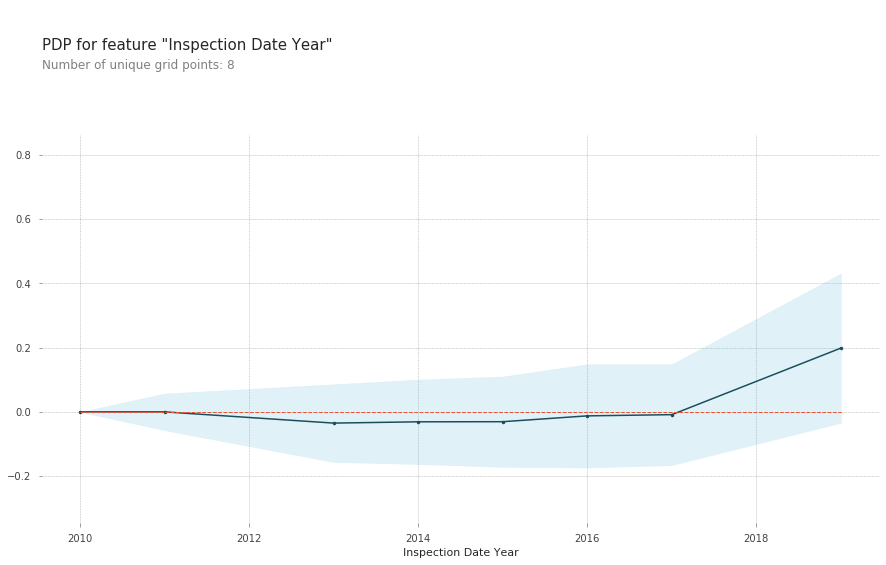

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Inspection Date Year'

isolated_feature = pdp_isolate(
    model=m2_gbt_in_pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated_feature, feature_name=feature)

### How do our model's predictions vary with different values of the 2 most important features, Inspection Type and Inspection Year?

In [0]:
# # Plot 2-feature PDP of Inspection Type and Inspection Year:
# from pdpbox.pdp import pdp_interact, pdp_interact_plot

# features = ['Inspection Type', 'Inspection Type Year']

# interaction = pdp_interact(
#     model=m2_gbt_in_pipeline, 
#     dataset=X_val, 
#     model_features=X_val.columns, 
#     features=features
# )

# # Plot it:
# pdp_interact_plot(interaction, plot_type='grid', feature_names=features)